https://neo4j.com/developer/guide-build-a-recommendation-engine/

In [1]:
import pandas as pd
from py2neo import Graph
graph = Graph("bolt://localhost:7687", user='neo4j', password='newPassword')
# graph = Graph()

In [2]:
import matplotlib 
import matplotlib.pyplot as plt

## Part 1, Recommendations

#### 1. Collaborative or preferential filtering.

Collaborative filtering is based on the idea that people like things similar to other things they like, and things that are liked by other people with similar taste.
In a retail environment, collaborative filtering is based on the idea that people shop at places where there is a commonality in style, quality, price and appeal, and shops are similarly liked by people with similar preferences.
In a retail graph such as this behaviour or preferences arre revealed by clusters of nodes. 

Check that our database is running:

In [3]:
graph.run("CALL db.schema.visualization()").data()

[{'nodes': [(_-2:Merchant {constraints: ['CONSTRAINT ON ( merchant:Merchant ) ASSERT (merchant.franchisename) IS UNIQUE'], indexes: [], name: 'Merchant'}),
   (_-1:Client {constraints: ['CONSTRAINT ON ( client:Client ) ASSERT (client.dedupestatic) IS UNIQUE'], indexes: [], name: 'Client'}),
   (_-3:Segment {constraints: ['CONSTRAINT ON ( segment:Segment ) ASSERT (segment.seg_l3_num) IS UNIQUE'], indexes: [], name: 'Segment'})],
  'relationships': [(Client)-[:TRANSACTED_AT {}]->(Merchant),
   (Merchant)-[:MERCHANT_VALUE_LINK {}]->(Merchant),
   (Merchant)-[:MERCHANT_LINK {}]->(Merchant),
   (Merchant)-[:MERCHANT_FEET_LINK {}]->(Merchant)]}]

### Goal 1: Co-merchant, co-client collaborative filtering with Neo4J Cypher

#### Find popular merchants:

In [5]:
popular_merchants_query = """
MATCH (merchant:Merchant)<-[transacted_at:TRANSACTED_AT]-(client)
WITH merchant.franchisename as merchant, count(transacted_at) as relationships
RETURN merchant, relationships 
ORDER BY relationships DESC
"""
graph.run(popular_merchants_query).to_data_frame()

,merchant,relationships
0,BOXER SUPERSTO,93970
1,NETFLIX.COM,84771
2,CheckersHyper,70692
3,payD Vodacom E,63589
4,Truworths,61202
...,...,...
92383,AIRBNB * HMTFEDBCW,1
92384,CAPE UNION MART HEIDELBER,1
92385,WIMPY LIFESTYLE TZANEEN,1
92386,MTN STORE WATERSTONE V,1


#### Find popular first-degree merchants (co-merchants 'merchant friends' linked via customers/Nedbank clients):

Choose 1 merchant, 'DIS-CHEM DAINFERN'

In [6]:
merchant='DIS-CHEM DAINFERN'

How many unique client relationships to this merchant?

In [7]:
merchantName='DIS-CHEM DAINFERN'
popular_merchants_query = """
MATCH (merchant:Merchant {franchisename:$merchantName})<-[transacted_at:TRANSACTED_AT]-(client)
RETURN count(client) AS uniqueClients
"""

graph.run(popular_merchants_query, {"merchantName": merchantName}).to_data_frame()

,uniqueClients
0,252


How many transactions and how much was spent at this merchant:

In [19]:
merchantName='DIS-CHEM DAINFERN'
popular_merchants_query = """
MATCH (merchant:Merchant {franchisename:$merchantName})<-[transacted_at:TRANSACTED_AT]-(client)
RETURN count(client) AS uniqueclients, sum(transacted_at.transactioncount) AS transactioncount, 
sum(transacted_at.transactionamount) AS transactionamount
"""

graph.run(popular_merchants_query, {"merchantName": merchantName}).to_data_frame()

,uniqueclients,transactioncount,transactionamount
0,252,387,-263574.71


Here we look at the number of client (of DIS-CHEM DAINFERN) transactions at first degree separated merchants:

In [14]:
merchantName='DIS-CHEM DAINFERN'
popular_merchants_query = """
MATCH (merchant1:Merchant {franchisename:$merchantName})<-[:TRANSACTED_AT]-()-[merchantTransactions:TRANSACTED_AT]->(merchant2:Merchant)
WHERE merchant1<>merchant2
RETURN DISTINCT(merchant2.franchisename) AS first_degree_merchant, 
       count(merchantTransactions) AS first_degree_merchant_transactions,
       sum(merchantTransactions.transactionamount) as transactionamount,
       sum(merchantTransactions.transactioncount) as transactioncount
ORDER BY first_degree_merchant_transactions DESC
"""

graph.run(popular_merchants_query, {"merchantName": merchantName}).to_data_frame()

,first_degree_merchant,first_degree_merchant_transactions,transactionamount,transactioncount
0,PNP CRP DEINFERN SQUAR,116,-144490.67,252
1,WOOLWORTHS MAROUN SQ,111,-325572.49,314
2,Spar Broadacres Spar,72,-132158.20,185
3,Clicks Dairnfern,62,-49656.84,96
4,NETFLIX.COM,50,-8047.28,52
...,...,...,...,...
1219,PNP CLOTHING BENMORE G,1,-249.99,1
1220,Cltx Kingfisher S S Fo,1,-793.55,1
1221,POS Clicks INS FUNDS,1,-8.60,1
1222,COTTON ON FOUR,1,-562.00,1


In [15]:
popular_df=graph.run(popular_merchants_query, {"merchantName": merchantName}).to_data_frame()

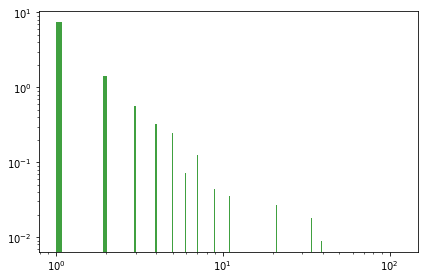

In [16]:
fig1, ax1 = plt.subplots()
ax1.hist(pd.Series(popular_df['first_degree_merchant_transactions'].dropna()), 1250, density=True, facecolor='g', alpha=0.75)
ax1.set_xscale("log")
ax1.set_yscale("log")
plt.tight_layout()
plt.show()

#### There is almost a 50% chance of a Dischem DSQ shopper shopping at a PNP DSQ too!  ie, a dischem shopper made their way to PNP 1/2 times.  But of those clients who visited both Dischem Dainfern Square and PNP DSQ committed the more than half the number of transactions at PNP

Choose the most popular first degree merchant (to DIS-CHEM dainfern) (Check the spelling!), 'PNP CRP DEINFERN SQUAR'

In [20]:
merchantName='PNP CRP DEINFERN SQUAR'

How many unique customer relationships to this merchant:

In [21]:
popular_merchants_query = """
MATCH (merchant1:Merchant {franchisename:$merchantName})<-[:TRANSACTED_AT]-(client)
RETURN count(client) AS uniqueClients
"""
graph.run(popular_merchants_query, {"merchantName": merchantName}).to_data_frame()

,uniqueClients
0,384


Take 'PNP CRP DEINFERN SQUAR' as merchant zero and extract its first degree separated merchants:

In [23]:
merchantName='PNP CRP DEINFERN SQUAR'
popular_merchants_query = """
MATCH (merchant1:Merchant {franchisename:$merchantName})<-[:TRANSACTED_AT]-()-[merchantTransactions:TRANSACTED_AT]->(merchant2:Merchant)
WHERE merchant1<>merchant2
RETURN DISTINCT(merchant2.franchisename) AS first_degree_merchant, 
       count(merchantTransactions) AS first_degree_merchant_transactions,
       sum(merchantTransactions.transactionamount) as transactionamount,
       sum(merchantTransactions.transactioncount) as transactioncount
ORDER BY first_degree_merchant_transactions DESC
"""

graph.run(popular_merchants_query, {"merchantName": merchantName}).to_data_frame()

,first_degree_merchant,first_degree_merchant_transactions,transactionamount,transactioncount
0,DIS-CHEM DAINFERN,116,-150853.25,232
1,WOOLWORTHS MAROUN SQ,112,-318951.90,308
2,Clicks Dairnfern,101,-72091.11,147
3,Spar Broadacres Spar,94,-180051.66,221
4,NETFLIX.COM,74,-12224.00,78
...,...,...,...,...
1930,MRP HOME FOURW,1,-1565.84,1
1931,WOOLWORTHS VALLEY CENTNTR,1,-311.45,1
1932,PNP CRP HYDEPARK,1,-2520.87,1
1933,SASOL MINTYS ROSEBAN,1,-1776.66,3


There is hence a less that 30% (116/383) chance of a client visiting PNP and Dischem at this mall, ie all the PNP shoppers less than 1/3 made their way to Dischem.  But the probability of PNP-WW is also less (112/383) than DISCHEM-WW (111/252)

#### Carry on with DSQ merchant, PNP CRP DEINFERN SQUAR.

#### Merchant of Merchant transactions

In [24]:
merchantName='PNP CRP DEINFERN SQUAR'
merchantName_clients = """
MATCH (merchant:Merchant {franchisename: $merchantName})<-[:TRANSACTED_AT]-(client:Client)
RETURN client.dedupestatic AS client, size((client)-[:TRANSACTED_AT]-(merchant)) AS merchantTransactions,
size((client)-[:TRANSACTED_AT]-()) AS momTransactions
ORDER BY momTransactions DESC
LIMIT 20
"""

graph.run(merchantName_clients,  {"merchantName": merchantName}).to_data_frame()

,client,merchantTransactions,momTransactions
0,1.91030354806e+11,1,51
1,1.918431743e+11,1,44
2,1.100845365e+11,1,42
3,1.46345547626e+11,1,40
4,1.91493430605e+11,1,40
5,1.10425265102e+11,1,39
6,1.54000226594e+11,1,37
7,1.93019260407e+11,1,36
8,1.10126319502e+11,1,36
9,2.110886841e+11,1,34


### Find the co-merchants, the merchant-of-merchants

In [25]:
# franchisename='DIS-CHEM DAINFERN'
# clicks='Clicks Dairnfern'
def merchantdf_fn(franchisename):
    competition_query = """MATCH (client:Client)-[transaction:TRANSACTED_AT]-(merchant:Merchant {franchisename:$franchisename})
    RETURN client.dedupestatic as client, merchant.franchisename"""
    return graph.run(competition_query,  {"franchisename":franchisename}).to_data_frame()

def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 

In [26]:
merchantName='PNP CRP DEINFERN SQUAR'
collaborations_query = """
MATCH (:Merchant {franchisename: $merchantName})<-[:TRANSACTED_AT]-(client)-[:TRANSACTED_AT]->(momMerchant:Merchant)
RETURN momMerchant.franchisename AS momMerchant, count(*) AS coMerchantsCount
ORDER BY coMerchantsCount DESC
LIMIT 10
"""

graph.run(collaborations_query,  {"merchantName": merchantName}).to_data_frame()

,momMerchant,coMerchantsCount
0,DIS-CHEM DAINFERN,116
1,WOOLWORTHS MAROUN SQ,112
2,Clicks Dairnfern,101
3,Spar Broadacres Spar,94
4,NETFLIX.COM,74
5,PNP CRP DEINFE,63
6,WOOLWORTHS MAROUN SQUAR,58
7,Makro Riversands,52
8,PNP CRP FOURWAYS,50
9,WOOLWORTHS MAR,48


Find all the clients who shopped at Dischem and Clicks, Dainfern:

In [27]:
dischem_df=merchantdf_fn(franchisename='DIS-CHEM DAINFERN')
clicks_df=merchantdf_fn(franchisename='Clicks Dairnfern')

In [28]:
print("There are: ",len(set(dischem_df.client)), " unique DISCHEM clients and ", len(set(clicks_df.client)), " unique clients at CLICKS")

There are:  252  unique DISCHEM clients and  251  unique clients at CLICKS


Calculate the clients who shopped at both:

In [29]:
len(intersection(list(dischem_df.client),list(clicks_df.client)))

62

## Recommendations

### Motive, means and alibi

Look at the Dainfern Square 'complex/network' of merchants.  Take the top four by transactioncount or feet, being
'PNP CRP DEINFERN SQUAR',
'WOOLWORTHS MAROUN SQ',
'Spar Broadacres Spar',
'Clicks Dairnfern'.  
We find the clients who shopped at these, ie had the 'means' to shop at DIS-CHEM DAINFERN but didn't.  The had no alibi!

In [33]:
victim='DIS-CHEM DAINFERN'
means1='PNP CRP DEINFERN SQUAR'
means2='WOOLWORTHS MAROUN SQ'
means3='Spar Broadacres Spar'
means4='Clicks Dairnfern'

recommendations_query = """
MATCH (client:Client)-[:TRANSACTED_AT]-(m:Merchant) 
WHERE m.franchisename IN [$means1,$means2,$means3,$means4] AND NOT (client)-[:TRANSACTED_AT]-(m:Merchant {franchisename:$victim})
RETURN  client.dedupestatic as client"""

df=graph.run(recommendations_query,  {"victim": victim, "means1":means1,"means2":means2,
                                  "means3":means3,"means4":means4}).to_data_frame()

In [34]:
df

,client
0,1.20000229728e+11
1,1.91602204709e+11
2,2.11497704705e+11
3,1.91862230227e+11
4,1.10104738405e+11
...,...
1911,1.91103172202e+11
1912,1.91196977307e+11
1913,1.91030354806e+11
1914,1.20000415053e+11


In [36]:
victim='DIS-CHEM DAINFERN'
means4='Clicks Dairnfern'

recommendations_query = """
MATCH (client:Client)-[:TRANSACTED_AT]-(m:Merchant) 
WHERE m.franchisename IN [$means4] AND NOT (client)-[:TRANSACTED_AT]-(m:Merchant {franchisename:$victim})
RETURN  client.dedupestatic as client"""

df=graph.run(recommendations_query,  {"victim": victim, "means4":means4}).to_data_frame()

In [37]:
df

,client
0,1.10226300609e+11
1,1.54000469268e+11
2,1.91184958102e+11
3,1.91352215506e+11
4,1.10272980501e+11
...,...
246,1.91103172202e+11
247,1.91196977307e+11
248,1.91030354806e+11
249,1.20000415053e+11


### Page Ranking

Copy of 03_Recommendations_Part1.ipynb

https://www.cs.princeton.edu/~chazelle/courses/BIB/pagerank.htm

PageRank is an algorithm that measures connectivity of nodes. (connectivity is also referred to as the transitive influence) It can be computed by either 
1. iteratively distributing one node’s rank (originally based on degree) over its neighbors or 
2. by randomly traversing the graph and counting the frequency of hitting each node during these walks.

The following PageRank code is run over the whole graph to find out the most influential Merchant in terms of transactions:

#### Find popular merchants:

In [ ]:
popular_merchants_query = """
MATCH (merchant:Merchant)
RETURN merchant.franchisename, size((merchant)<-[:TRANSACTED_AT]-()) AS transactions
ORDER BY transactions DESC
LIMIT 10
"""

graph.run(popular_merchants_query).to_data_frame()

#### Pick one merchant, 'franchisename:'DIS-CHEM DAINFERN' 

In [ ]:
franchisename='DIS-CHEM DAINFERN'

In [ ]:
query = """
MATCH (m:Merchant {franchisename:$franchisename})
RETURN m.companyname
"""
graph.run(query, {"franchisename": franchisename}).to_data_frame()

In [ ]:
# query = """
#     CALL db.index.fulltext.createNodeIndex('merchants', ['Merchant'], ['franchisename'])
# """
# graph.run(query).data()

#### Retrieve FULLTEXT indices:

In [ ]:
query = """
CALL db.indexes()
YIELD name, uniqueness, type
WHERE type = "FULLTEXT"
RETURN *
"""
graph.run(query).to_data_frame()

#### Conduct a full text search on franchisename over the entire graph:

In [ ]:
query = """
CALL db.index.fulltext.queryNodes("merchants", "columbine")
YIELD node, score
RETURN node.franchisename, score, [(client)-[:TRANSACTED_AT]-(node) | client.dedupestatic] AS clients
LIMIT 10
"""
graph.run(query).to_data_frame()

In [ ]:
my_node = graph.run("""MATCH (merchant:Merchant {companyname:'DISCHEM'})
RETURN merchant """).data()

In [ ]:
my_node

In [ ]:
my_node = graph.run("""MATCH (merchant:Merchant {franchisename:'DIS-CHEM DAINFERN'})-[:TRANSACTED_AT]-(c:Client) 
RETURN merchant.franchisename, c.dedupestatic """).data()

In [ ]:
len(my_node)

Retrieve the customers this merchant had and how many transactions they had:

In [ ]:
author_articles_query = """
MATCH (:Merchant {franchisename: $franchisename})<-[:TRANSACTED_AT]-(client)
RETURN client.dedupestatic AS client, size((client)-[:TRANSACTED_AT]->()) AS other_transactions
ORDER BY other_transactions DESC
LIMIT 20
"""
graph.run(author_articles_query,  {"franchisename": franchisename}).to_data_frame()

Retrieve the customers this merchant had and how many other transactions they had EXCLUDING franchisename:

In [ ]:
author_articles_query = """
MATCH (merchant1:Merchant {franchisename: $franchisename})<-[:TRANSACTED_AT]-(client)-[:TRANSACTED_AT]->(merchant2)
WHERE merchant1<>merchant2
RETURN client.dedupestatic AS client, count((client)-[:TRANSACTED_AT]->(merchant2)) AS other_transactions
ORDER BY other_transactions DESC
LIMIT 20
"""
graph.run(author_articles_query,  {"franchisename": franchisename}).to_data_frame()

In [ ]:
collaborations_query = """
MATCH (:Merchant {franchisename: $franchisename})<-[:TRANSACTED_AT]-(client)-[:TRANSACTED_AT]->(comerchant)
RETURN comerchant.franchisename AS franchisename, count(*) AS cotransactions
ORDER BY cotransactions DESC
LIMIT 10
"""

graph.run(collaborations_query,  {"franchisename": franchisename}).to_data_frame()

In [ ]:
my_node = graph.run("""MATCH (dischem:Merchant {franchisename:'DIS-CHEM DAINFERN'})-[:TRANSACTED_AT]-(c:Client)-
[:TRANSACTED_AT]-(other:Merchant)
WHERE other.franchisename<>dischem.franchisename 
RETURN dischem.franchisename, c.dedupestatic, other.franchisename, other.companyname""").data()

In [ ]:
my_node

In [ ]:
my_node = graph.run("""MATCH (dischem:Merchant {franchisename:'DIS-CHEM DAINFERN'})-[:TRANSACTED_AT]-(c:Client)-
[:TRANSACTED_AT]-(other:Merchant)
WHERE other.franchisename<>dischem.franchisename 
RETURN DISTINCT(c.dedupestatic), count(DISTINCT other)""").data()
my_node

In [ ]:
my_node = graph.run("""MATCH (dischem:Merchant {franchisename:'DIS-CHEM DAINFERN'})-[:TRANSACTED_AT]-(c:Client)-
[othertransaction:TRANSACTED_AT]-(other:Merchant)
WHERE other.franchisename<>dischem.franchisename 
RETURN DISTINCT(other.franchisename) AS other_franchisename, count(othertransaction) AS number_transactions""").data()
my_node

In [ ]:
my_node = graph.run("""MATCH (dischem:Merchant {franchisename:'DIS-CHEM DAINFERN'})-[:TRANSACTED_AT]-(c:Client)-
[othertransaction:TRANSACTED_AT]-(other:Merchant)
WHERE other.franchisename<>dischem.franchisename 
WITH other.franchisename AS other_franchisename, count(othertransaction) AS number_transactions 
RETURN DISTINCT(other_franchisename), number_transactions""").data()
my_node

In [ ]:
my_node = graph.run("""MATCH (dischem:Merchant {franchisename:'DIS-CHEM DAINFERN'})-[:TRANSACTED_AT]-(c0:Client)
MATCH (c1:Client {dedupestatic:'2.11279273006e+11'})  
WHERE c0.dedupestatic <> c1.dedupestatic  
RETURN gds.alpha.linkprediction.commonNeighbors(c0, c1)""").data()
my_node

In [ ]:
my_node = graph.run("""MATCH (dischem:Merchant {franchisename:'DIS-CHEM DAINFERN'})-[:TRANSACTED_AT]-(c0:Client) 
MATCH (dischem:Merchant {franchisename:'DIS-CHEM DAINFERN'})-[:TRANSACTED_AT]-(c1:Client) 
WHERE c0.dedupestatic <> c1.dedupestatic AND gds.alpha.linkprediction.commonNeighbors(c0, c1)>5 
RETURN c0.dedupestatic, c1.dedupestatic, gds.alpha.linkprediction.commonNeighbors(c0, c1) as commons""").data()
my_node

In [ ]:
my_node = graph.run("""MATCH (dischem:Merchant {franchisename:'DIS-CHEM DAINFERN'})-[:TRANSACTED_AT]-(c0:Client)
WITH collect(distinct c0) as clients 
MATCH (dischem:Merchant {franchisename:'DIS-CHEM DAINFERN'})-[:TRANSACTED_AT]-(c1:Client) 
WHERE c1 NOT in clients AND gds.alpha.linkprediction.commonNeighbors(c0, c1)>5 
RETURN c0.dedupestatic, c1.dedupestatic""").data()
my_node

In [ ]:
 MATCH (p1:Person {name: 'Michael'})
 MATCH (p2:Person {name: 'Karin'})
 RETURN gds.alpha.linkprediction.commonNeighbors(p1, p2) AS score

In [ ]:
my_node = graph.run("""MATCH (dischem:Merchant {franchisename:'DIS-CHEM DAINFERN'})-[:TRANSACTED_AT]-(c0:Client) 
MATCH (dischem:Merchant {franchisename:'DIS-CHEM DAINFERN'})-[:TRANSACTED_AT]-(c1:Client)
WHERE c0.dedupestatic <> c1.dedupestatic  
RETURN DISTINCT(c0.dedupestatic), DISTINCT(c1.dedupestatic)""").data()
my_node

#### Peek into the file:

In [ ]:
my_node = graph.run("""MATCH (merchant:Merchant {franchisename:'DIS-CHEM DAINFERN'})-[:TRANSACTED_AT]-(c:Client) 
RETURN merchant.franchisename, c.dedupestatic """).data()

In [ ]:
data

In [ ]:
# crimes_header.csv
filename='/var/lib/neo4j/import/beats.csv'
beats = pd.read_csv(filename,nrows=10)
beats

In [ ]:
# crimes_header.csv
filename='/var/lib/neo4j/import/crimes_header.csv'
crimes_header_csv = pd.read_csv(filename,nrows=10)
crimes_header_csv

In [ ]:
filename='/var/lib/neo4j/import/crimes.csv'
crimes_csv = pd.read_csv(filename,nrows=10)
crimes_csv

In [ ]:
import csv
filename='/media/lnr-ai/christo/github_repos/graphing/data/clientswipes_202003_neo4j.csv'
with open(filename) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0

In [ ]:
    for row in csv_reader:
        if line_count == 0:
            print(f'Column names are {", ".join(row)}')
            line_count += 1
        else:
            print(f'\t{row[0]} works in the {row[1]} department, and was born in {row[2]}.')
            line_count += 1
    print(f'Processed {line_count} lines.')

In [ ]:
dedupegroup_list=list(set(df.Dedupegroup))

In [ ]:
for dedupestatic in list(set(dedupegroup_list)):
    print('Doing dedupestatic: ', dedupestatic, ' at index: ', dedupegroup_list.index(dedupestatic), ' of ', len(dedupegroup_list))        
    client_param_dict={"dedupestatic":dedupestatic}
    graph.run("MERGE (client:Client {dedupestatic:{dedupestatic}})", client_param_dict)

In [ ]:
for dedupe in dedupegroup_list:
    gf=df[df.Dedupegroup==dedupe].copy()
    print('Doing dedupestatic: ', dedupe, ' at index: ', dedupegroup_list.index(dedupe), ' of ', len(dedupegroup_list))    
    for dedupestatic,companyname,franchisename,companyindex,class_id,discretionary,division_id,group_id,subclass_id,channel,TransactionAmount,TransactionDate in zip(gf.Dedupegroup, gf.companyname, gf.franchisename,gf.companyindex,gf.class_id,gf.discretionary,gf.division_id,gf.group_id,gf.subclass_id,gf.channel,gf.TransactionAmount,gf.TransactionDate):

        client_param_dict={"dedupestatic":dedupestatic}
        company_param_dict={"companyname":companyname,
                  "franchisename":franchisename,
                  "companyindex":companyindex,
                  "class_id":class_id,
                  "discretionary":discretionary,
                  "division_id":division_id,
                  "group_id":group_id,
                  "subclass_id":subclass_id,
                  "channel":channel}
        franchise_param_dict={
              "franchisename":franchisename,"companyname":companyname,}
        transaction_param_dict={"dedupestatic":dedupestatic,
              "franchisename":franchisename,
    #           "companyindex":companyindex,
              "amount":amount,
              "date":date}
        owner_param_dict={"companyname":companyname,
              "franchisename":franchisename}
    #   ------------------------------------------------------------------------------------------
        graph.run("MERGE (client:Client {dedupestatic:{dedupestatic}})", client_param_dict)
    #   ------------------------------------------------------------------------------------------    
        graph.run("""MERGE (franchise:Franchise 
        {
        franchisename:{franchisename},
        companyname:{companyname}})
        """, franchise_param_dict)
    #   ------------------------------------------------------------------------------------------
        graph.run("""
        MERGE (company:Company 
        {
        companyname: {companyname}, 
        companyindex: {companyindex}}) ON CREATE SET company.channel={channel},
        company.class_id={class_id},
        company.discretionary={discretionary},
        company.division_id={division_id},
        company.group_id={group_id},
        company.subclass_id={subclass_id},
        company.channel={channel}
        """, company_param_dict)
    #   ------------------------------------------------------------------------------------------
        graph.run("""MATCH (client:Client {dedupestatic:{dedupestatic}}),(franchise:Franchise { franchisename: {franchisename} })
        MERGE (client)-[t:transacted]->(franchise)
        ON CREATE SET t.amount=[{amount}], t.date=[{date}]
        ON MATCH SET t.amount=t.amount+{amount}, t.date=t.date+{date}""", transaction_param_dict)
    #   ------------------------------------------------------------------------------------------
        graph.run("""MATCH (franchise:Franchise {franchisename:{franchisename}}),(company:Company { companyname: {companyname} })
        MERGE (franchise)-[t:owned]->(company)""", owner_param_dict)    

In [ ]:
dedupestatic=dedupegroup_list[0]
companyname=list(gf.companyname)[0]
franchisename=list(gf.franchisename)[0]
companyindex=list(gf.companyindex)[0]
class_id=list(gf.class_id)[0]
discretionary=list(gf.discretionary)[0]
division_id=list(gf.division_id)[0]
group_id=list(gf.group_id)[0]
subclass_id=list(gf.subclass_id)[0]
channel=list(gf.channel)[0]
amount=list(gf.TransactionAmount)[0]
date=list(gf.TransactionDate)[0]
# companyindex=list(gf.companyindex)[0]
# class_id=list(gf.class_id)[0]
# discretionary=list(gf.discretionary)[0]
# division_id=list(gf.division_id)[0]
# group_id=list(gf.group_id)[0]
# subclass_id=list(gf.subclass_id)[0]
# channel=list(gf.channel)[0]

In [ ]:
client_param_dict={"dedupestatic":dedupestatic}

In [ ]:
company_param_dict={"companyname":companyname,
          "franchisename":franchisename,
          "companyindex":companyindex,
          "class_id":class_id,
          "discretionary":discretionary,
          "division_id":division_id,
          "group_id":group_id,
          "subclass_id":subclass_id,
          "channel":channel}

In [ ]:
franchise_param_dict={
          "franchisename":franchisename,"companyname":companyname,}

In [ ]:
transaction_param_dict={"dedupestatic":dedupestatic,
          "franchisename":franchisename,
#           "companyindex":companyindex,
          "amount":amount,
          "date":date}

In [ ]:
owner_param_dict={"companyname":companyname,
          "franchisename":franchisename}

In [ ]:
graph.run("MERGE (client:Client {dedupestatic:{dedupestatic}})", client_param_dict)

In [ ]:
graph.run("""
MERGE (franchise:Franchise 
{
franchisename:{franchisename},
companyname:{companyname}})
""", franchise_param_dict)

In [ ]:
graph.run("""
MERGE (company:Company 
{
companyname: {companyname}, 
companyindex: {companyindex}}) ON CREATE SET company.channel={channel},
company.class_id={class_id},
company.discretionary={discretionary},
company.division_id={division_id},
company.group_id={group_id},
company.subclass_id={subclass_id},
company.channel={channel}
""", company_param_dict)

In [ ]:
graph.run("""MATCH (client:Client {dedupestatic:{dedupestatic}}),(franchise:Franchise { franchisename: {franchisename} })
MERGE (client)-[t:transacted]->(franchise)
ON CREATE SET t.amount=[{amount}], t.date=[{date}]
ON MATCH SET t.amount=t.amount+{amount}, t.date=t.date+{date}""", transaction_param_dict)


In [ ]:
graph.run("""MATCH (franchise:Franchise {franchisename:{franchisename}}),(company:Company { companyname: {companyname} })
MERGE (franchise)-[t:owned]->(company)""", owner_param_dict)